# Извлечение мнений из новостных текстов посредством промптинга LLM (Mistral Small Version 25.03)

В данном проекте мы попытаемся с помощью промптинга настроить выдачу кортежей мнений моделью Mistral Small на данных соревнования RuOpinionNE-2024.

Устанавливаем необходимую зависимость.

In [ ]:
!pip install mistralai

## Промптинг модели

Используем API непосредственно через собственный сервис La Platforme от Mistral AI. (Платно им пользоваться не получится, но создать аккаунт и пользоваться бесплатно - да).

In [ ]:
from os import truncate
from google.colab import userdata
from mistralai import Mistral, models
from mistralai.utils import BackoffStrategy, RetryConfig

api_key = userdata.get("MISTRAL_API_KEY")
model = "mistral-small-latest"

client = Mistral(
    api_key=api_key,
    retry_config=RetryConfig("backoff", BackoffStrategy(1, 50, 1.1, 100), True),
)

def get_opinions(prompt, text):
    chat_response = client.chat.complete(
        model= model,
        messages = [
            {
                "role": "user",
                "content": f"{prompt}\n{text}",
            },
        ],
        temperature = 0.2
    )
    return chat_response.choices[0].message.content

Задаем изначальный промпт. Просим модель приводить свое рассуждение в надежде, что это улучшит качество.

In [ ]:
PROMPT = """Задача: выполнить сентимент-анализ текста с выделением кортежей мнений.
Кортеж мнения состоит из следующих полей:
  - "Source" - именованная сущность, являющаяся источником мнения
  - "Target" - именованная сущность, являющаяся объектом мнения
  - "Polarity" - полярность мнения (положительная или отрицательная)
  - "Polar_expression" - выражение, которое передает мнение
Для каждого выраженного в тексте мнения необходимо определить его источник, объект и конкретное выражение, которое содержит это мнение.
Если источник мнения отсутствует, то Source = "NULL". Если источником мнения является автор новостного текста, то Source = "AUTHOR".
Источник мнения не может быть выражен местоимением, в этом случае также Source = "NULL".
В тексте может быть несколько мнений, либо не быть явно выраженных мнений.
Текст имеет новостной характер, однако помни, что репортер или издание сами не являются источниками мнений, о которых сообщают.
Ожидаемый формат ответа:

```json
[
  {
    "Source": "", # часть текста с источником мнения
    "Target": "", # часть текста с объектом мнения
    "Polarity": "" # "POS" for positive, "NEG" for negative
    "Polar_expression": "" # часть текста с выражением мнения
  },
  # ...
]
```

Сначала приведи рассуждения, где выделены и проанализированы все найденные в тексте мнения.
После пройди по каждому мнению и проверь:
  - источник и объект мнения указаны в том же падеже, в котором они встречаются в тексте (указать, в каком)
  - выражение мнения также должно быть дословно по тексту (может содержать внутри объект, в таком случае его нужно также сохранить внутри строки)
Затем приведи конечный результат в виде JSON. В ответе должен быть только один JSON-объект, если мнений не было, оставь его пустым списком.

Текст:
"""

In [ ]:
sample_news_text = "Как сообщал Коммерсант 6 июня, член бюро высшего совета партии Андрей Исаев не исключил даже лишения Муртазы Рахимова партбилета. Муртаза отметил, что Исаев превышает свои полномочия."

print(get_opinions(PROMPT, sample_news_text))

### Рассуждения

1. **Первое мнение:**
   - **Источник:** Муртаза Рахимов
   - **Объект:** Андрей Исаев
   - **Выражение мнения:** "превышает свои полномочия"
   - **Полярность:** Отрицательная

   Рассуждение: В тексте Муртаза Рахимов выражает мнение о том, что Андрей Исаев превышает свои полномочия. Это мнение имеет отрицательную полярность.

2. **Второе мнение:**
   - **Источник:** Андрей Исаев
   - **Объект:** Муртаза Рахимов
   - **Выражение мнения:** "не исключил даже лишения Муртазы Рахимова партбилета"
   - **Полярность:** Отрицательная

   Рассуждение: Андрей Исаев не исключает лишения Муртазы Рахимова партбилета, что также является отрицательным мнением.

### Проверка

1. **Первое мнение:**
   - **Источник:** Муртаза (в родительном падеже)
   - **Объект:** Исаев (в именительном падеже)
   - **Выражение мнения:** "превышает свои полномочия" (дословно)

2. **Второе мнение:**
   - **Источник:** Андрей Исаев (в именительном падеже)
   - **Объект:** Муртаза Рахимов (в родительном 

Вполне адекватный ответ.

## Постобработка ответов модели

Создаем функции для возвращения интервала (треьуется форматом) и преобразования строчного формата в JSON (так же требуется форматом).

In [ ]:
import json

def get_interval(text, phrase):
    if phrase == 'AUTHOR':
        return 'NULL'
    if phrase == 'NULL':
        return '0:0'
    start_index = text.find(phrase)
    # если точная строка не найдена, вернем всю строку
    if start_index == -1:
        return f"0:{len(text)}"
    end_index = start_index + len(phrase)
    return f"{start_index}:{end_index}"

def extract_json(response):
    stack = []
    for i, char in enumerate(response):
        if char in '{[':
            stack.append((i, char))
        elif char in '}]':
            if not stack:
                continue
            start_i, start_char = stack.pop()
            if (char == '}' and start_char != '{') or (char == ']' and start_char != '['):
                # Mismatched brackets, reset stack
                stack = []
                continue
            if not stack:
                # Potential JSON found
                json_str = response[start_i:i+1]
                try:
                    return json.loads(json_str)
                except json.JSONDecodeError:
                    # Invalid JSON, continue searching
                    continue
    return []

def string2json(sample, output):
    # Определяем идентификатор
    sent_id = sample["sent_id"]
    # Определяем предложение
    text = sample["text"]

    predicted_json = {
      "sent_id": sent_id,
      "text": text,
      "opinions": []
    }

    # Преобразуем строку в Python-объект (список)
    opinions_list = extract_json(output)

    if opinions_list == []:
      return predicted_json

    if opinions_list[0]['Polarity'] not in ('POS', 'NEG'):
      return predicted_json

    # Создаем новый JSON-объект
    predicted_json = {
        "sent_id": sent_id,
        "text": text,
        "opinions": [{"Source": [[opinions_list[0]["Source"]], [get_interval(text, opinions_list[0]["Source"])]],
                      "Target": [[opinions_list[0]["Target"]], [get_interval(text, opinions_list[0]["Target"])]],
                      "Polar_expression": [[opinions_list[0]["Polar_expression"]], [get_interval(text, opinions_list[0]["Polar_expression"])]],
                      "Polarity": opinions_list[0]["Polarity"]}]
        }
    return predicted_json

## Загрузка данных

In [ ]:
import requests

def load_json(path, url):

  r = requests.get(url, allow_redirects=True)
  with open(path, 'wb') as st:
    st.write(r.content)

  with open(path, 'r', encoding = 'utf8') as file:
    data = list()
    for line in file:
        data_entry = json.loads(line)
        data.append(data_entry)
  return data

In [ ]:
url = 'https://raw.githubusercontent.com/dialogue-evaluation/RuOpinionNE-2024/master/train.jsonl'
train_data = load_json("train.jsonl", url)
len(train_data)

2556

In [ ]:
url = "https://raw.githubusercontent.com/dialogue-evaluation/RuOpinionNE-2024/master/validation_labeled.jsonl"
valid_data = load_json("validation.jsonl", url)
len(valid_data)

1316

In [ ]:
url = "https://raw.githubusercontent.com/dialogue-evaluation/RuOpinionNE-2024/refs/heads/master/test.jsonl"
test_data = load_json("test.jsonl", url)
len(test_data)

803

### Анализ

Анализ скопирован из файла datasets_&_baselines.ipynb.

Проанализиуем обучающую выборку.

Определим минимальную, максимальную и среднюю длину текста. Отобразим распределение на графике.

In [ ]:
lens = [len(x['text'].split()) for x in train_data]

max_l, min_l, mean_l = max(lens), min(lens), sum(lens)/len(lens)

print(f'Минимальная длина текста: {min_l}')
print(f'Максимальная длина текста: {max_l}')
print(f'Средняя длина текста: {mean_l:.3f}')

Минимальная длина текста: 5
Максимальная длина текста: 201
Средняя длина текста: 18.059


<BarContainer object of 64 artists>

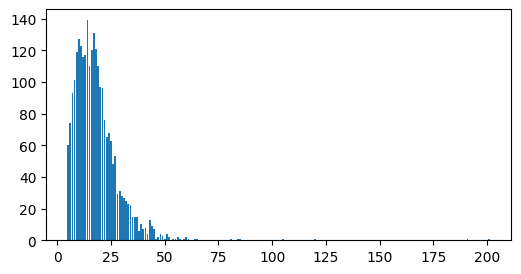

In [ ]:
from collections import Counter
from matplotlib import pyplot as plt

len_counts = Counter(lens)
plt.figure(figsize = (6,3))
plt.bar(len_counts.keys(), len_counts.values())

Выведем самый длинный текст.

In [ ]:
for elem in train_data:
    if len(elem['text'].split()) == max_l:
        print(elem['sent_id'])
        print(elem['text'])

2047
Макеенко распространил следующее жёсткое видеообращение к Президенту Украины Виктору Януковичу: Я Владимир Макеенко обращаюсь лично к Вам господин Президент и к руководителям силовых структур События происходящие сегодня в столице Украины это трагедия всего украинского народа Я ответственно сообщаю что готов сделать все возможное для прекращения братоубийства и кровопролития в сердце Украины на Майдане Независимости Человеческая жизнь должна быть высшей ценностью в нашем государстве и ничто не может противоречить этому принципу В подтверждение своих слов я принял решение выйти из рядов Партии регионов и принять личную ответственность за жизнедеятельность города Киева Так сложилась моя судьба что в это тяжелое время на меня возложена огромная ответственность за каждого киевлянина Мы должны руководствоваться только интересами народа это единственный шанс сохранить жизнь людей Никакая власть не стоит человеческих жертв Ни один олигарх не погиб ни один политик не погиб я как руководит

Определим количество текстов, состоящих из более чем одного предложения:

In [ ]:
count = 0
for elem in train_data:
    text = elem['text']
    if '\n' in text or '.' in text[:-1]:
        count+=1
print(count)

85


Для дальнейшего анализа преобразуем обучающую выборку в датафрейм, где 1 мнение = 1 строка.

In [ ]:
opinions = []
for elem in train_data:
    for op in elem['opinions']:
        # источник и интервал
        if len(op['Source'][0]) > 1:
            source_text = op['Source'][0]
            source_span = op['Source'][1]
        else:
            source_text = op['Source'][0][0]
            source_span = op['Source'][1][0]
        # объект и интервал
        if len(op['Target'][0]) > 1:
            target_text = op['Target'][0]
            target_span = op['Target'][1]
        else:
            target_text = op['Target'][0][0]
            target_span = op['Target'][1][0]
        # выражение и интервал
        if len(op['Polar_expression'][0]) > 1:
            exp_text = op['Polar_expression'][0]
            exp_span = op['Polar_expression'][1]
        else:
            exp_text = op['Polar_expression'][0][0]
            exp_span = op['Polar_expression'][1][0]
        opinions.append([elem['sent_id'], elem['text'], source_text, target_text, exp_text,
                       op['Polarity'], source_span, target_span, exp_span])

In [ ]:
import pandas as pd
cols = ['sent_id', 'text', 'Source', 'Target', 'Polar_expression', 'Polarity', 'Source_span', 'Target_span', 'Polar_expression_span']
df = pd.DataFrame(opinions, columns = cols)
df

,sent_id,text,Source,Target,Polar_expression,Polarity,Source_span,Target_span,Polar_expression_span
0,0,Президент Башкирии Муртаза Рахимов в очередной...,Муртаза Рахимов,главу своей администрации,поменять,NEG,19:34,66:91,57:65
1,1,"Вчера он уволил Азамата Сагитова, который возг...",NULL,Азамата Сагитова,уволил,NEG,0:0,16:32,9:15
2,3,"Как сообщил ""Ъ"" глава пресс-службы башкирского...",Муртаза Рахимов,главы своей администрации,отставке,NEG,83:98,125:150,116:124
3,5,Этому назначению предшествовал громкий скандал...,NULL,Радия Хабирова,громкий скандал,NEG,0:0,109:123,31:46
4,6,Год назад в защиту опального башкирского чинов...,Единая Россия,Хабирова,защиту,POS,70:83,111:119,12:18
...,...,...,...,...,...,...,...,...,...
2899,2553,"По его словам, он весьма тронут тёплым приёмом...",NULL,медиков,профессиональной помощью,POS,0:0,84:91,49:73
2900,2554,"Пациент отметил, что здравоохранение Джибути н...",NULL,Джибути,на низком уровне,NEG,0:0,37:44,55:71
2901,2555,"Кроме того, военные обеих стран проведут совме...",Гуан Байлин,Джибути,укрепления дружбы,POS,103:114,139:146,68:85
2902,2555,"Кроме того, военные обеих стран проведут совме...",Джибути,Гуан Байлин,укрепления дружбы,POS,139:146,103:114,68:85


Оценим распределение классов тональности.

Polarity
NEG    1730
POS    1174
Name: count, dtype: int64


<Axes: xlabel='Polarity'>

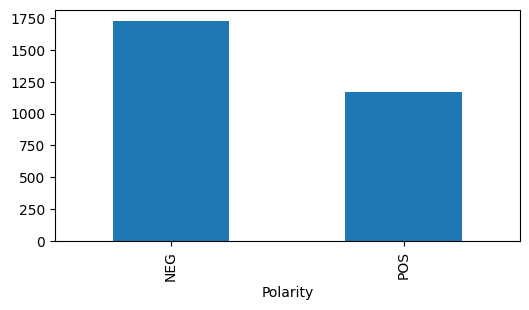

In [ ]:
print(df['Polarity'].value_counts())

plt.figure(figsize = (6,3))
df['Polarity'].value_counts().plot.bar()

Определим число текстов с множественными мнениями и отобразим распределение на графике.

In [ ]:
textcount = Counter(df['text'].value_counts())
textcount

Counter({23: 1,
         14: 1,
         12: 2,
         11: 1,
         10: 2,
         9: 1,
         8: 4,
         7: 12,
         6: 14,
         5: 37,
         4: 90,
         3: 169,
         2: 391,
         1: 769})

<BarContainer object of 14 artists>

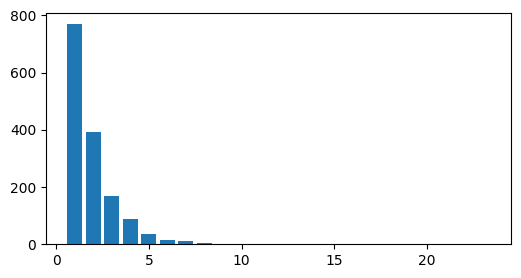

In [ ]:
plt.figure(figsize = (6,3))
plt.bar(textcount.keys(), textcount.values())

Посчитаем максимальную и среднюю длину для источника, объекта и выражения. Выведем примеры.

In [ ]:
sources = []
for item in df['Source']:
    if isinstance(item, str):
        sources.append(item)
    else:
        sources+=item
max_s = max([len(x.split()) for x in sources])
mean_s = sum([len(x.split()) for x in sources])/len(sources)
print(f'Максимальная длина источника: {max_s}')
print(f'Средняя длина источника: {mean_s:.3f}')

print(f'Самый длиный источник:')
for item in df['Source']:
    if isinstance(item, str) and len(item.split()) == max_s:
        print(f'"{item}"')

Максимальная длина источника: 7
Средняя длина источника: 1.372
Самый длиный источник:
"Революционные вооружённые силы Колумбии — Армия народа"
"мировой судебный участок 363 Хамовнического района Москвы"


In [ ]:
targets = []
for item in df['Target']:
    if isinstance(item, str):
        targets.append(item)
    else:
        targets+=item
max_t = max([len(x.split()) for x in targets])
mean_t = sum([len(x.split()) for x in targets])/len(targets)
print(f'Максимальная длина объекта: {max_t}')
print(f'Средняя длина объекта: {mean_t:.3f}')

for item in df['Target']:
    if isinstance(item, str) and len(item.split()) == max_t:
        print(f'Самый длиный объект:\n"{item}"')

Максимальная длина объекта: 12
Средняя длина объекта: 1.499
Самый длиный объект:
"Акционерным коммерческим банком содействия благотворительности и духовному развитию Отечества ПЕРЕСВЕТ Акционерное общество"


In [ ]:
expressions = list()
for item in df['Polar_expression']:
    if isinstance(item, str):
        expressions.append(item)
    else:
        expressions+=item
max_e = max([len(x.split()) for x in expressions])
mean_e = sum([len(x.split()) for x in expressions])/len(expressions)
print(f'Максимальная длина выражения: {max_e}')
print(f'Средняя длина выражения: {mean_e:.3f}')

for item in df['Polar_expression']:
    if isinstance(item, str) and len(item.split()) == max_e:
        print(f'Самое длиное выражение:\n"{item}"')

Максимальная длина выражения: 18
Средняя длина выражения: 2.562
Самое длиное выражение:
"заговоре с целью организации взрывов в нью-йоркском метро и совершения терактов в городах Великобритании и других европейских стран"


Определим самые частые источники.

In [ ]:
df['Source'].value_counts()

,count
Source,
NULL,897
AUTHOR,384
США,28
Трамп,15
Владимир Путин,14
...,...
Эрик,1
Time,1
Гарсии,1


Посчитаем количество разрывных и множественных источников, объектов и выражений.

In [ ]:
s, t, e = 0, 0, 0
for i, row in df.iterrows():
    if isinstance(row['Source'], list):
        s+=1
    if isinstance(row['Target'], list):
        t+=1
    if isinstance(row['Polar_expression'], list):
        e+=1

print(f'Множественный/ фрагментированный источник: {s}')
print(f'Множественный/ фрагментированный объект: {t}')
print(f'Множественное/ фрагментированное выражение: {e}')

Множественный/ фрагментированный источник: 0
Множественный/ фрагментированный объект: 4
Множественное/ фрагментированное выражение: 19


Выведем примеры.

In [ ]:
for i, row in df.iterrows():
    if isinstance(row['Polar_expression'], list):
        print(row['Polar_expression'], row['Polar_expression_span'], sep = '\n')

['снял', 'ограничения на реализацию']
['28:32', '125:150']
['понизило', 'рейтинг']
['102:110', '134:141']
['крупные заемщики', 'имеют некоторые признаки аффилированности друг с другом либо с акционерами или менеджментом банка']
['94:110', '124:221']
['выпускники', 'становятся участниками ДТП']
['132:142', '196:222']
['имеет', 'необходимую поддержку']
['26:31', '48:69']
['имеет', 'необходимую поддержку']
['26:31', '48:69']
['На пост', 'готовят']
['0:7', '63:70']
['В Словакию', 'отправиться']
['0:10', '37:48']
['разрушившим', 'экономику']
['177:188', '211:220']
['контакты', 'приостановлены']
['30:38', '56:70']
['стала', 'донором']
['101:106', '110:117']
['Ситуация', 'остаётся нестабильной']
['0:8', '23:44']
['Желаю', 'здоровья']
['306:311', '333:341']
['играл', 'за']
['32:37', '51:53']
['лишить', 'мандата']
['171:177', '189:196']
['выиграл', 'чемпионский титул']
['29:36', '49:66']
['причастности', 'к убийству']
['59:71', '79:89']
['устраивали праздничные мероприятия', 'после смерти барон

## Evaluation

Для оценки качества используется скрипт evaluation.py, который необходимо скачать из соревнования.

In [ ]:
!wget -q https://raw.githubusercontent.com/dialogue-evaluation/RuOpinionNE-2024/master/codalab/evaluation.py

In [ ]:
import evaluation

### Train data evaluation

Попробуем посчитать качество на части тренировочной выборки.

In [ ]:
from tqdm.auto import tqdm
from time import time, sleep

In [ ]:
sample_size = 100

progress_bar = tqdm(range(sample_size))
train_output = []

for sample in train_data[:sample_size]:
  sample_output = get_opinions(PROMPT, sample["text"])
  train_output.append(sample_output)
  progress_bar.update(1)
  sleep(1) # avoid rate limit

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
train_json_output = []
for i in range(len(train_output)):
  train_json_output.append(string2json(train_data[i], train_output[i]))

In [ ]:
evaluation.do_eval_core(train_data[:sample_size], train_json_output)

0.27968636168406735

Качество в целом неплохое, но можно улучшить промпт.

### Использование асинхронных методов для оптимизации вычислений

Бесплатный доступ к Mistral API имеет ограничения - rate limit в 1 запрос в секунду. Для того, чтобы ускорить обработку большого количества данных, используем асинхронные методы, а также добавим обработку ошибок с повторным опросом в случае получения ошибки rate limit exceeded.

In [ ]:
!pip install aiometer

In [ ]:
import asyncio
import aiometer
from tqdm.asyncio import tqdm as tqdm_asyncio


async def async_get_response(sample):
    text = sample["text"]
    result = {"sent_id": sample["sent_id"], "text": text, "response": None}
    try:
      chat_response = await client.chat.complete_async(
        model=model,
        messages = [
            {
                "role": "user",
                "content": f"{PROMPT}\n{text}",
            },
        ],
        temperature = 0.2,
      )
      result["response"] = chat_response.choices[0].message.content
    except models.SDKError as e:
      result["response"] = None
    return result

async def gather_responses(input_data):
    async with aiometer.amap(async_get_response, input_data, max_at_once=10, max_per_second=0.9) as results:
        return [
            response async
            for response in tqdm_asyncio(
                results, total=len(input_data), position=0, leave=True
            )
        ]

async def get_all_responses_with_retries(input_data):
    all_responses = []
    data_without_response = input_data

    while len(data_without_response) > 0:
        responses = await gather_responses(data_without_response)
        error_responses = []
        for resp in responses:
            if resp["response"] is not None:
                all_responses.append(resp)
            else:
                error_responses.append(resp)
        error_ids = [item["sent_id"] for item in error_responses]
        data_without_response = [
            item for item in input_data
            if item["sent_id"] in error_ids
        ]
        await asyncio.sleep(1)

    return sorted(all_responses, key=lambda x: x["sent_id"])

Далее для оценки качества будем использовать данные из валидационной выборки (берем с конца, где больше примеров с непустыми мнениями).

In [ ]:
sample_size = 100

responses = await get_all_responses_with_retries(valid_data[-sample_size:])

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


In [ ]:
responses_json = [
    string2json(valid_data[item["sent_id"]], item["response"])
    for item in responses
]
responses_json[6]

{'sent_id': 1222,
 'text': 'Джэнис Хан — члена городского совета Лос-Анджелеса недавно предложила сделать тоже самое и в этом крупнейшем в Калифорнии городе.',
 'opinions': []}

In [ ]:
evaluation.do_eval_core(valid_data[-sample_size:], responses_json)

0.20870520151165964

Качество на валидационной выборке очевидно хуже. Попробуем скорректировать промпт.

## Prompt engineering

Уберем из промпта просьбу о рассуждении и добавим некоторые примеры мнений.

In [ ]:
PROMPT = """Задача: выполнить сентимент-анализ текста с выделением кортежей мнений.
Кортеж мнения состоит из следующих полей:
  - "Source" - именованная сущность, являющаяся источником мнения
  - "Target" - именованная сущность, являющаяся объектом мнения
  - "Polarity" - полярность мнения (положительная или отрицательная)
  - "Polar_expression" - выражение, которое передает мнение
Для каждого выраженного в тексте мнения необходимо определить его источник, объект и конкретное выражение, которое содержит это мнение.
Если источник мнения отсутствует, то Source = "NULL". Если источником мнения является автор новостного текста, то Source = "AUTHOR".
Источник мнения не может быть выражен местоимением, в этом случае также Source = "NULL".
В тексте может быть несколько мнений, либо не быть явно выраженных мнений.
Текст имеет новостной характер, однако помни, что репортер или издание сами не являются источниками мнений, о которых сообщают.
Ожидаемый формат ответа:

```json
[
  {
    "Source": "", # часть текста с источником мнения
    "Target": "", # часть текста с объектом мнения
    "Polar_expression": "", # часть текста с выражением мнения
    "Polarity": "" # "POS" for positive, "NEG" for negative
  },
  # ...
]
```

Приведи конечный результат в виде JSON. В ответе должен быть только один JSON-объект, если мнений не было, оставь его пустым списком.

Ниже представлены примеры выполнения задачи:
***Текст***
Премьер-министр Молдовы осудил террориста за бесчеловечные и жестокие действия.
***Ответ***
[{"Source": "Премьер-министр Молдовы", "Target": "террориста", "Polarity": "NEG", "Polar_expression": "бесчеловечные и жестокие действия"}]
***Текст***
Знаменитая актриса продемонстрировала человечность и простоту, достойную уважения публики.
***Ответ***
[{"Source": "AUTHOR", "Target": "актриса", "Polarity": "POS", "Polar_expression": "продемонстрировала человечность и простоту, достойную уважения публики"}]
***Текст***
Монеты, выпускаемые в знак благодарности всем трудившимся для преодоления пандемии COVID-19 (работникам здравоохранения, торговли, санитарии, транспорта) будут выпущены номиналами в 10 и 20 форинтов.
***Ответ***
[{"Source": "NULL", "Target": "работникам здравоохранения", "Polarity": "POS", "Polar_expression": "трудившимся для преодоления"}]

Проанализируй таким же образом следующий текст.
"""

In [ ]:
sample_size = 100

responses = await get_all_responses_with_retries(valid_data[-sample_size:])
responses_json = [
    string2json(valid_data[item["sent_id"]], item["response"])
    for item in responses
]
evaluation.do_eval_core(valid_data[-sample_size:], responses_json)

100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


0.3069060005700612

Видим, что качество повышается, если добавить примеры (few-shot), а также не просить приводить рассуждения, а только конечный результат.

## Подготовка и сохранение результатов для CodaLab

### Старый метод

Сначала попробуем пройти по данным старым методом (что выходит дольше).

In [ ]:
progress_bar = tqdm(range(len(test_data)))
test_output = []
test_indices = []

for sample in test_data:
  sample_output = get_opinions(PROMPT, sample["text"])
  test_output.append(sample_output)
  test_indices.append(sample["sent_id"])
  progress_bar.update(1)
  sleep(1) # avoid rate limit

  0%|          | 0/803 [00:00<?, ?it/s]

In [ ]:
test_json_output = []
for i, output in zip(test_indices, test_output):
  test_json_output.append(string2json(test_data[i], output))

Для успокоения и в целом на всякий случай сравниваем файлы, чтобы удостовериться, что совпадает количество предложений и их номера.

In [ ]:
evaluation.do_eval_core(test_data, test_json_output)

0.0

### Новый метод (async)

Используем новый метод (что выходит быстрее).

In [ ]:
test_responses = await get_all_responses_with_retries(test_data)

100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


In [ ]:
test_json_output = [
    string2json(test_data[item["sent_id"]], item["response"])
    for item in test_responses
]
len(test_json_output)

803

In [ ]:
evaluation.do_eval_core(test_data, test_json_output)

0.0

### Cохранение архива с файлом результатов

In [ ]:
with open('test_predictions.jsonl', 'w') as outfile:
    for entry in test_json_output:
        json.dump(entry, outfile, ensure_ascii=False)
        outfile.write('\n')

In [ ]:
!zip test_predictions.zip test_predictions.jsonl

updating: test_predictions.jsonl (deflated 78%)


## Заключение и финальная метрика

Мы получили финальное значение метрики равное 0.28.

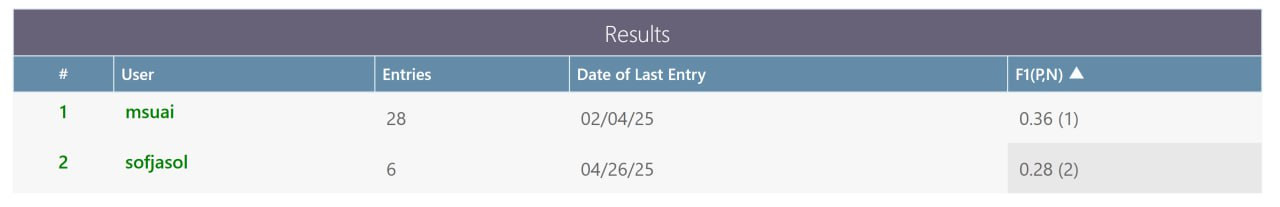

Какие выводы можно сделать:
- для данной задачи достаточно few-shot, а chain-of-thought оказывается избыточным
- для ускорения процесса можно использовать асинхронный метод/функции
- модель достаточно хорошо понимает требуемый формат вывода, неплохо справляется в очевидных случаях, в менее очевидных случаях (мнение автора, отсутствие источника, фрагментированные мнения) модель довольно часто ошибается
- модель так же хорошо понимает, когда мнений в тексте нет
- слабости модели - опредеение границ мнений и определение самих источников и объектов
- имеет склонность искажать падеж источников и объектов